In [ ]:
!pip install torchmetrics

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
from torchmetrics.functional import retrieval_normalized_dcg
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("intern_task.csv")

In [ ]:
data.head()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000


In [ ]:
print(data.shape)
print(data['rank'].unique())
print(data['query_id'].nunique())

(235258, 146)
[0 1 2 4 3]
2000


In [ ]:
data['query_id'].unique()

array([   10,    25,    40, ..., 29965, 29980, 29995])

In [ ]:
for col in data.columns:
  nans = data[col].isna().sum()
  if nans:
    print(f"{col} has: {nans} nan values")

In [ ]:
data_no_queryid = data.drop(['query_id'], axis=1)
data_no_queryid.head()

,rank,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,0.000000,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,0.004251,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,0.008501,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,0.012752,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,0.017003,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000


In [ ]:
train, test = train_test_split(data_no_queryid, test_size=0.3)
train, val = train_test_split(train, test_size=0.1)

In [ ]:
X = train.iloc[:, 1:].values
y = train.iloc[:, 0].values
X_val = val.iloc[:, 1:].values
y_val = val.iloc[:, 0].values

In [ ]:
train, test = train_test_split(data, test_size=0.3)
train, val = train_test_split(train, test_size=0.1)

In [ ]:
print(train.shape)
print(test.shape)
print(val.shape)

(148212, 145)
(70578, 145)
(16468, 145)


In [ ]:
def plot_losses(train_losses, val_losses):
    fig, ax = plt.subplots(1,figsize=(15, 5))
    ax.plot(range(1, len(train_losses) + 1), train_losses, label='train')
    ax.plot(range(1, len(val_losses) + 1), val_losses, label='val')

    if max(train_losses) / min(train_losses) > 10:
        ax.set_yscale('log')

    ax.set_xlabel('epoch')
    ax.legend()

    ax.set_ylabel('loss')
    plt.show()


In [ ]:
def train_and_validate(model, optimizer, criterion, train_loader, val_loader, num_epochs, train_len, val_len):
    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0
        pbar = tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}') \

        for i, (X_batch, y_batch) in enumerate(pbar, 1):

            predictions = model(X_batch)
            #y = torch.zeros(5)
            #y[y_batch.item()] = 1
            loss = criterion(predictions, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                running_loss += loss.item() * X_batch.shape[0]

        train_losses += [running_loss / train_len]

        model.eval()
        running_loss = 0
        pbar = tqdm(val_loader, desc=f'Validating {epoch}/{num_epochs}') \

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            #y = torch.zeros(5)
            #y[y_batch.item()] = 1
            with torch.no_grad():
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)

                running_loss += loss.item() * X_batch.shape[0]

        val_losses += [running_loss / val_len]

        plot_losses(train_losses, val_losses)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
dataset_train = TensorDataset(torch.tensor(scaler.fit_transform(X), dtype=torch.float32), torch.tensor(y))
dataset_val = TensorDataset(torch.tensor(scaler.fit_transform(X_val), dtype=torch.float32), torch.tensor(y_val))

Training 1/6:   0%|          | 0/148212 [00:00<?, ?it/s]

Validating 1/6:   0%|          | 0/16468 [00:00<?, ?it/s]

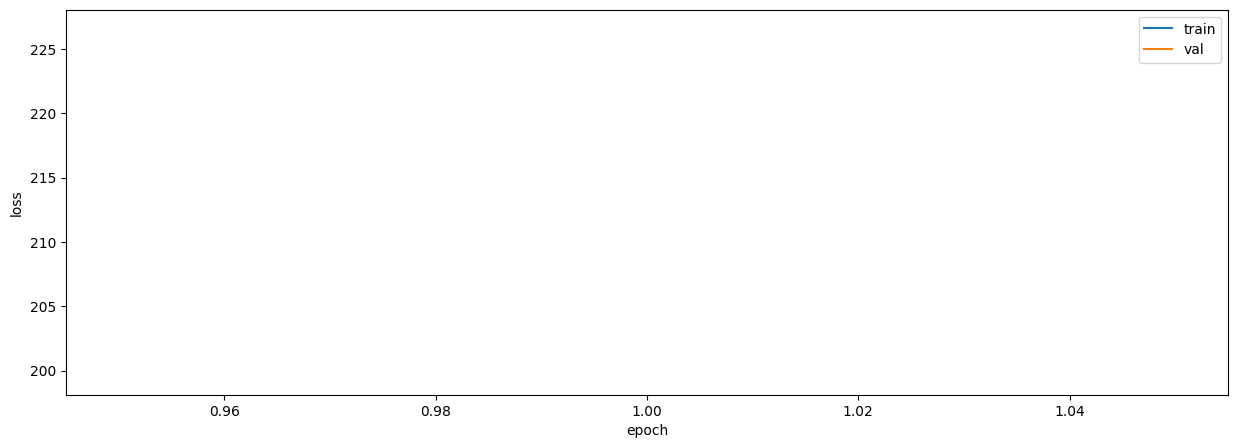

Training 2/6:   0%|          | 0/148212 [00:00<?, ?it/s]

Validating 2/6:   0%|          | 0/16468 [00:00<?, ?it/s]

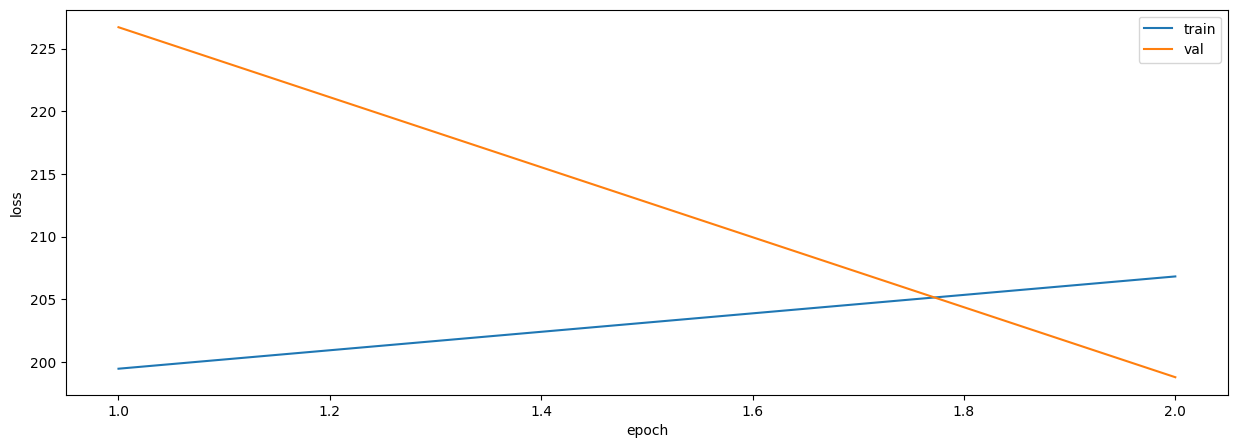

Training 3/6:   0%|          | 0/148212 [00:00<?, ?it/s]

Validating 3/6:   0%|          | 0/16468 [00:00<?, ?it/s]

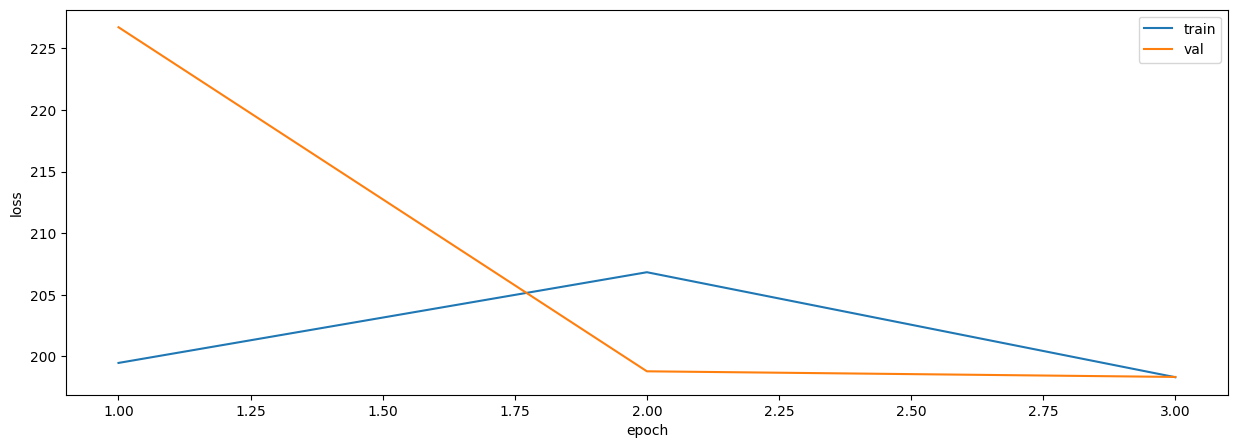

Training 4/6:   0%|          | 0/148212 [00:00<?, ?it/s]

Validating 4/6:   0%|          | 0/16468 [00:00<?, ?it/s]

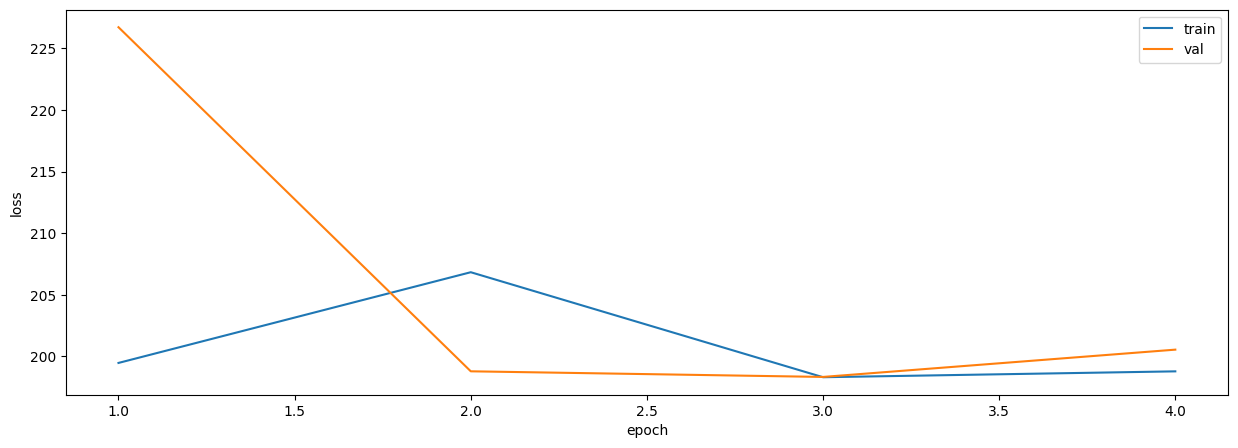

Training 5/6:   0%|          | 0/148212 [00:00<?, ?it/s]

Validating 5/6:   0%|          | 0/16468 [00:00<?, ?it/s]

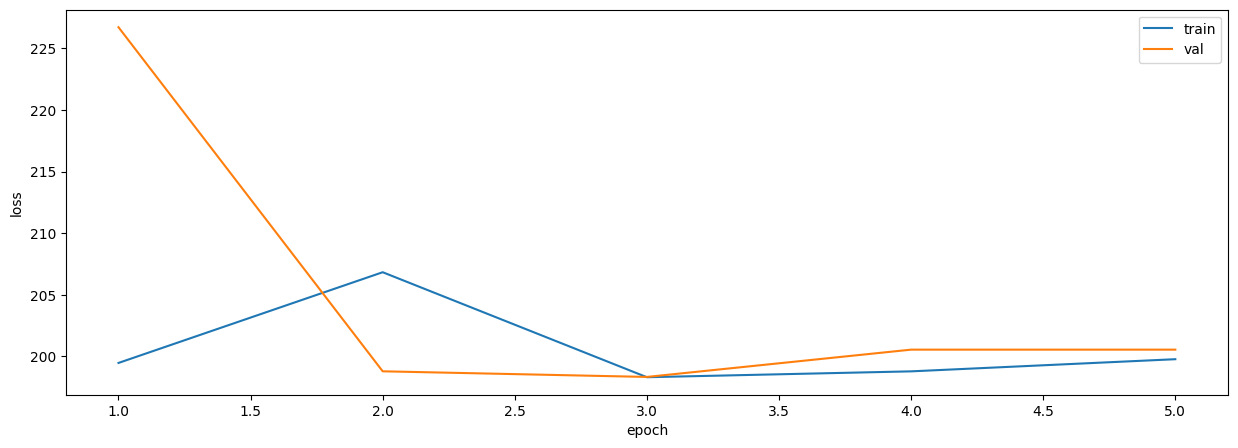

Training 6/6:   0%|          | 0/148212 [00:00<?, ?it/s]

Validating 6/6:   0%|          | 0/16468 [00:00<?, ?it/s]

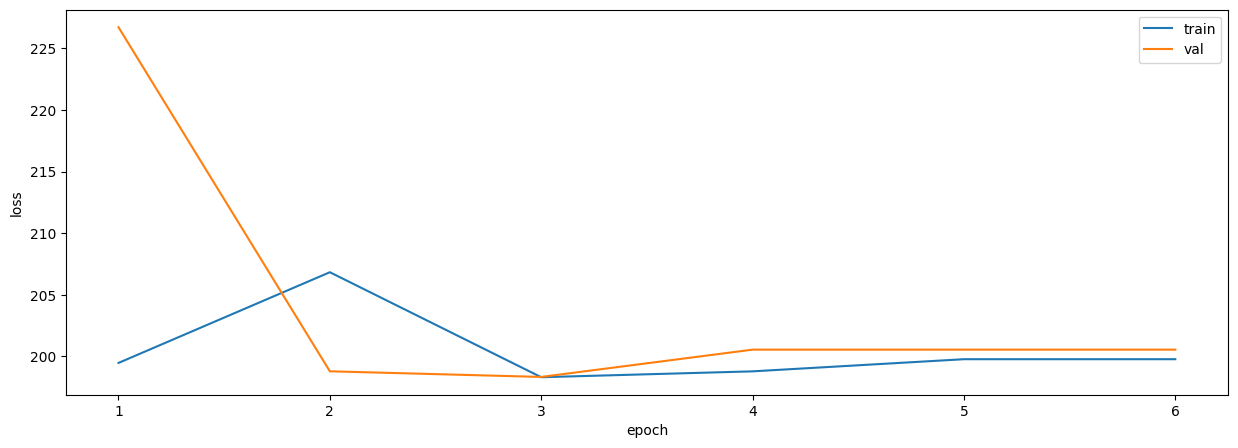

In [ ]:
model = nn.Sequential(
    nn.Linear(144, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 5),
    nn.Softmax(dim=0),
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_and_validate(model, optimizer, criterion, dataset_train, dataset_val, 6, train.shape[0], val.shape[0])

In [ ]:
def count_ndcg(model, test, nn=True):
  metrics = []
  for query in test['query_id'].unique():
      X_test = test[test['query_id'] == query].drop(['rank', 'query_id'],axis=1)
      y_test = test[test['query_id'] == query]['rank']
      if nn:
        pred = torch.argmax(model(torch.tensor(scaler.fit_transform(X_test), dtype=torch.float32)), dim=1)
        print(pred)
        metrics.append(retrieval_normalized_dcg(torch.tensor(pred, dtype=torch.float32), torch.tensor(y_test.to_numpy(), dtype=torch.float32)))
      else:
        pred = model.predict(scaler.fit_transform(X_test))
        metrics.append(retrieval_normalized_dcg(torch.tensor(pred, dtype=torch.float32), torch.tensor(y_test.to_numpy(), dtype=torch.float32)))
  return metrics


In [ ]:
res_nn = count_ndcg(model, test)

In [ ]:
print(f"average ncdg5 across all unique queries = {sum(res_nn)/len(res_nn)}")

average ncdg5 across all unique queries = 0.6342945098876953


In [ ]:
model_baseline = LogisticRegression().fit(scaler.fit_transform(X), y)

In [ ]:
res = count_ndcg(model_baseline, test, False)

In [ ]:
print(f"average ncdg5 across all unique queries with the baseline model = {sum(res)/len(res)}")

average ncdg5 across all unique queries with the baseline model = 0.6656854748725891


The NN requires more optimization but I ran out of time